In [1]:
import base64
import hashlib
from Crypto.Cipher import AES
from Crypto import Random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BLOCK_SIZE = AES.block_size

In [3]:
def pad(s: str) -> str:
    '''
    Padds the bytestring to given block size
    '''
    return s + (BLOCK_SIZE - len(s) % BLOCK_SIZE) * chr(BLOCK_SIZE - len(s) % BLOCK_SIZE)

def unpad(s: str) -> str:
    '''
    Removes the padding from the str
    '''
    return s[:-ord(s[len(s) - 1:])]

def sha256(s: str) -> bytes:
    return hashlib.sha256(s.encode('utf-8')).digest() # digest?

In [4]:
text = 'Hello world'
padded = pad(text)
assert text == unpad(padded)
text, padded

('Hello world', 'Hello world\x05\x05\x05\x05\x05')

In [5]:
def encrypt(plain_text: str, key: str) -> bytes:
    private_key = sha256(key) 
    
    plain_text = pad(plain_text).encode('utf-8')
    
    # XXX: Block size needs to be 16 bytes
    iv = Random.new().read(AES.block_size) # iv?

    # XXX: Private key can be only 16, 128 or 256 bytes
    cipher = AES.new(private_key, AES.MODE_CBC, iv)
    
    # Base64 encode to avoid problems with printing
    return base64.b64encode(iv + cipher.encrypt(plain_text))

def decrypt(cipher_text: bytes, key: str) -> bytes:
    # 
    private_key = sha256(key)
    cipher_text = base64.b64decode(cipher_text)
    
    # First block contains the seed
    iv = cipher_text[:BLOCK_SIZE]
    cipher = AES.new(private_key, AES.MODE_CBC, iv)
    return unpad(cipher.decrypt(cipher_text[BLOCK_SIZE:]))

In [6]:
msg, pssd = 'Hello world', 'pssd'
encrypted = encrypt(msg, pssd)
decrypted = decrypt(encrypted, pssd)
assert msg == decrypted.decode('utf-8'), 'Decrypted and encrypted text is not the same'
encrypted, decrypted

(b'JmkV38GBHoLsiixkmySsUbQuA4V7FEupZ+OcmG8A8RQ=', b'Hello world')

In [7]:
mbytes = base64.b64decode(encrypted[BLOCK_SIZE:])
mbytes

b'\x9b$\xacQ\xb4.\x03\x85{\x14K\xa9g\xe3\x9c\x98o\x00\xf1\x14'

In [8]:
ar = np.frombuffer(mbytes, dtype=np.uint8)
ar

array([155,  36, 172,  81, 180,  46,   3, 133, 123,  20,  75, 169, 103,
       227, 156, 152, 111,   0, 241,  20], dtype=uint8)

<BarContainer object of 256 artists>

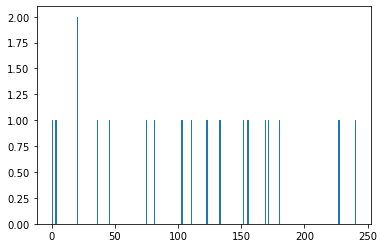

In [9]:
plt.hist(ar, bins=256)[-1]

<BarContainer object of 256 artists>

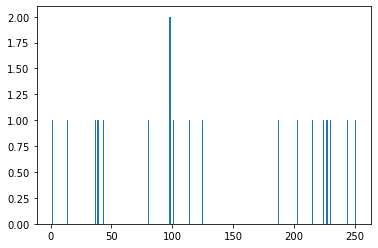

In [10]:
plt.hist(np.random.randint(low=0, high=256, size=len(mbytes)), bins=256)[-1]

In [11]:
from Crypto.Cipher import DES

In [12]:
def encrypt_des(string, key):
    assert len(key) == 8, 'Key needs to be 8 bytes long'
    string = string.encode('utf-8')
    key = key.encode('utf-8')
    cipher = DES.new(key, DES.MODE_OFB)
    encrypted = cipher.iv + cipher.encrypt(string)
    return encrypted

def decrypt_des(string, key):
    iv = string[:8]
    cipher = DES.new(key.encode('utf-8'), DES.MODE_OFB, iv)
    decrypted = cipher.decrypt(string[8:])
    return decrypted

In [13]:
key = '12345678'
text = 'Hello'
e = encrypt_des(text, key)
d = decrypt_des(e, key)
assert text == d.decode('utf-8'), 'Encrypted and decrypted text is not the same'